# Garden city: A synthetic dataset and sandbox environment for analysis of pre-processing algorithms for GPS human mobility data

In [28]:
import pandas as pd
from zoneinfo import ZoneInfo
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy.random as npr
from shapely.geometry import box
from pprint import pprint

import nomad.io.base as loader
import nomad.city_gen as cg
from nomad.city_gen import City
import nomad.traj_gen as tg
from nomad.traj_gen import Agent, Population
import nomad.stop_detection.dbscan as DBSCAN
import nomad.stop_detection.lachesis as Lachesis

from nomad.constants import DEFAULT_SPEEDS, FAST_SPEEDS, SLOW_SPEEDS, DEFAULT_STILL_PROBS
from nomad.constants import FAST_STILL_PROBS, SLOW_STILL_PROBS, ALLOWED_BUILDINGS

## Generating an example city

To create a city, begin by initializing a `City` of the desired dimension. Then successively add `Buildings` to the city by defining their type, door location, and geometry (either as a bounding box or a list of block coordinates). The door coordinate is given by the street block that the building door faces. The final step is to call `city.get_street_graph()`, which generates the shortest paths between all blocks. As an example, we generate a city in which buildings are arranged in concentric rings, with a park in the center, following a ring of residences, a ring of retail locations, and, finally, an outer ring of workplaces.

In [29]:
# Initialize city
city = City(dimensions=(22, 22))
# add a park
city.add_building(building_type='park', door=(13, 11), geom=box(9, 9, 13, 13))
# add a home
city.add_building(building_type='home', door=(8, 8), blocks=[(7, 7), (7, 8)])

city.buildings_gdf

Checking door (13, 11) in streets_gdf index
streets_gdf index length: 484
First few index entries: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
Door (13, 11) in streets_gdf index: True
Checking door (8, 8) in streets_gdf index
streets_gdf index length: 468
First few index entries: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
Door (8, 8) in streets_gdf index: True


C:\Users\pacob\Desktop\Brain\Code Development\nomad\nomad\city_gen.py:327: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.buildings_gdf = pd.concat([self.buildings_gdf, new_row], axis=0)


,,,id,type,door_x,door_y,door_cell_x,door_cell_y,door_point,size,geometry
p-x13-y11,13,11,p-x13-y11,park,13.0,11.5,13,11,POINT (13 11.5),16,"POLYGON ((13 9, 13 13, 9 13, 9 9, 13 9))"
h-x8-y8,8,8,h-x8-y8,home,8.0,8.5,8,8,POINT (8 8.5),2,"POLYGON ((7 7, 8 7, 8 9, 7 9, 7 7))"


In [30]:
# add remaining homes
city.add_building('home', (9, 8), [(8, 7), (9, 7)])
city.add_building('home', (10, 8), [(10, 7)])
city.add_building('home', (11, 8), [(11, 7)])
city.add_building('home', (13, 6), [(13, 7)])
city.add_building('home', (14, 6), [(14, 7)])
city.add_building('home', (13, 8), [(14, 8)])
city.add_building('home', (13, 9), [(14, 9)])
city.add_building('home', (13, 11), [(14, 11)])
city.add_building('home', (13, 12), [(14, 12)])
city.add_building('home', (15, 13), [(14, 13)])
city.add_building('home', (13, 13), [(13, 14), (14, 14)])
city.add_building('home', (12, 13), [(12, 14)])
city.add_building('home', (11, 13), [(11, 14)])
city.add_building('home', (9, 13), [(9, 14)])
city.add_building('home', (8, 13), [(8, 14)])
city.add_building('home', (7, 15), [(7, 14)])
city.add_building('home', (6, 13), [(7, 13)])
city.add_building('home', (8, 12), [(7, 12)])
city.add_building('home', (8, 10), [(7, 10), (7, 9)])

# add workplaces
city.add_building('work', (3, 4), blocks=[(4, 4), (4, 5)])
city.add_building('work', (5, 3), blocks=[(5, 4), (5, 5)])
city.add_building('work', (6, 6), geom=box(6, 4, 8, 6))
city.add_building('work', (8, 6), geom=box(8, 4, 10, 6))
city.add_building('work', (12, 6), geom=box(11, 5, 14, 6))
city.add_building('work', (12, 3), geom=box(11, 4, 14, 5))
city.add_building('work', (15, 3), geom=box(14, 4, 17, 6))
city.add_building('work', (18, 4), geom=box(17, 4, 18, 6))
city.add_building('work', (18, 6), geom=box(16, 6, 18, 8))
city.add_building('work', (15, 9), geom=box(16, 8, 17, 10))
city.add_building('work', (18, 8), geom=box(17, 8, 18, 10))
city.add_building('work', (18, 10), geom=box(16, 10, 18, 12))
city.add_building('work', (18, 13), geom=box(16, 13, 18, 15))
city.add_building('work', (18, 15), geom=box(16, 15, 18, 16))
city.add_building('work', (15, 15), geom=box(15, 16, 18, 17))
city.add_building('work', (14, 15), blocks=[(14, 16)])
city.add_building('work', (16, 18), geom=box(16, 17, 18, 18))
city.add_building('work', (15, 18), geom=box(14, 17, 16, 18))
city.add_building('work', (13, 18), geom=box(12, 16, 14, 18))
city.add_building('work', (11, 18), geom=box(10, 17, 12, 18))
city.add_building('work', (11, 15), geom=box(10, 16, 12, 17))
city.add_building('work', (8, 18), geom=box(7, 16, 9, 18))
city.add_building('work', (6, 18), geom=box(5, 17, 7, 18))
city.add_building('work', (6, 15), geom=box(5, 16, 7, 17))
city.add_building('work', (3, 16), blocks=[(4, 16), (4, 17)])
city.add_building('work', (3, 13), geom=box(4, 13, 6, 16))
city.add_building('work', (6, 12), geom=box(4, 12, 6, 13))
city.add_building('work', (3, 10), blocks=[(4, 9), (4, 10)])
city.add_building('work', (6, 9), blocks=[(5, 9), (5, 10)])
city.add_building('work', (6, 8), blocks=[(4, 8), (5, 8)])
city.add_building('work', (3, 6), geom=box(4, 6, 6, 8))

# add retail places
city.add_building('retail', (0, 1), geom=box(1, 1, 3, 3))
city.add_building('retail', (3, 0), geom=box(3, 1, 5, 3))
city.add_building('retail', (5, 0), blocks=[(5, 1)])
city.add_building('retail', (5, 3), blocks=[(5, 2)])
city.add_building('retail', (6, 0), geom=box(6, 1, 8, 2))
city.add_building('retail', (6, 3), geom=box(6, 2, 8, 3))
city.add_building('retail', (9, 3), geom=box(9, 1, 10, 3))
city.add_building('retail', (12, 3), geom=box(10, 1, 13, 3))
city.add_building('retail', (14, 3), geom=box(13, 1, 15, 3))
city.add_building('retail', (15, 3), blocks=[(15, 2)])
city.add_building('retail', (16, 3), blocks=[(16, 2)])
city.add_building('retail', (15, 0), blocks=[(15, 1)])
city.add_building('retail', (16, 0), blocks=[(16, 1)])
city.add_building('retail', (17, 3), geom=box(17, 2, 19, 3))
city.add_building('retail', (18, 0), geom=box(17, 1, 19, 2))
city.add_building('retail', (19, 0), geom=box(19, 1, 21, 2))
city.add_building('retail', (18, 3), geom=box(19, 2, 21, 4))
city.add_building('retail', (18, 5), geom=box(19, 4, 21, 6))
city.add_building('retail', (18, 7), geom=box(19, 6, 20, 8))
city.add_building('retail', (21, 7), geom=box(20, 6, 21, 8))
city.add_building('retail', (18, 10), geom=box(19, 9, 21, 11))
city.add_building('retail', (18, 11), geom=box(19, 11, 21, 13))
city.add_building('retail', (18, 13), geom=box(19, 13, 20, 15))
city.add_building('retail', (21, 13), geom=box(20, 13, 21, 15))
city.add_building('retail', (21, 16), geom=box(19, 15, 21, 17))
city.add_building('retail', (21, 18), geom=box(19, 17, 21, 19))

city.add_building('retail', (21, 19), geom=box(19, 19, 21, 20))
city.add_building('retail', (20, 21), geom=box(19, 20, 21, 21))
city.add_building('retail', (17, 18), geom=box(17, 19, 18, 21))
city.add_building('retail', (16, 18), geom=box(16, 19, 17, 21))
city.add_building('retail', (14, 18), geom=box(13, 19, 16, 20))
city.add_building('retail', (15, 21), geom=box(14, 20, 16, 21))
city.add_building('retail', (13, 21), geom=box(12, 20, 14, 21))
city.add_building('retail', (12, 18), geom=box(12, 19, 13, 20))
city.add_building('retail', (11, 18), geom=box(10, 19, 12, 21))
city.add_building('retail', (9, 18), geom=box(8, 19, 10, 20))
city.add_building('retail', (9, 21), geom=box(8, 20, 10, 21))
city.add_building('retail', (6, 21), geom=box(5, 19, 7, 21))
city.add_building('retail', (4, 21), geom=box(3, 20, 5, 21))
city.add_building('retail', (4, 18), geom=box(3, 19, 5, 20))
city.add_building('retail', (2, 18), geom=box(2, 19, 3, 21))
city.add_building('retail', (1, 18), geom=box(1, 19, 2, 21))
city.add_building('retail', (3, 17), geom=box(1, 16, 3, 18))
city.add_building('retail', (3, 15), geom=box(1, 15, 3, 16))
city.add_building('retail', (3, 14), geom=box(1, 14, 3, 15))
city.add_building('retail', (3, 12), geom=box(1, 12, 3, 14))
city.add_building('retail', (3, 11), geom=box(1, 11, 3, 12))
city.add_building('retail', (3, 10), geom=box(1, 10, 3, 11))
city.add_building('retail', (3, 8), geom=box(1, 8, 3, 10))
city.add_building('retail', (3, 7), geom=box(1, 7, 3, 8))
city.add_building('retail', (0, 5), geom=box(1, 4, 2, 7))
city.add_building('retail', (3, 6), blocks=[(2, 6)])
city.add_building('retail', (3, 5), blocks=[(2, 5)])
city.add_building('retail', (3, 4), blocks=[(2, 4)])

city.get_street_graph()

# get_street_graph can be expensive so persisting is recommended
city.save_geopackage('../garden-city.gpkg')

Checking door (9, 8) in streets_gdf index
streets_gdf index length: 466
First few index entries: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
Door (9, 8) in streets_gdf index: True
Checking door (10, 8) in streets_gdf index
streets_gdf index length: 464
First few index entries: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
Door (10, 8) in streets_gdf index: True
Checking door (11, 8) in streets_gdf index
streets_gdf index length: 463
First few index entries: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
Door (11, 8) in streets_gdf index: True
Checking door (13, 6) in streets_gdf index
streets_gdf index length: 462
First few index entries: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
Door (13, 6) in streets_gdf index: True
Checking door (14, 6) in streets_gdf index
streets_gdf index length: 461
First few index entries: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
Door (14, 6) in streets_gdf index: True
Checking door (13, 8) in streets_gdf index
streets_gdf index length: 460
First few index entries: [(0, 0), 

C:\Users\pacob\Desktop\Brain\Code Development\nomad\.venv\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
C:\Users\pacob\Desktop\Brain\Code Development\nomad\.venv\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


For future uses, we can simply load the city gpkg file. 

In [9]:
city = City.from_geopackage('../garden-city.gpkg')

### Plotting the city

To visualize the city, we can call the `plot_city` method of the `City` class. Doors are plotted as gaps in the boundary of their building.

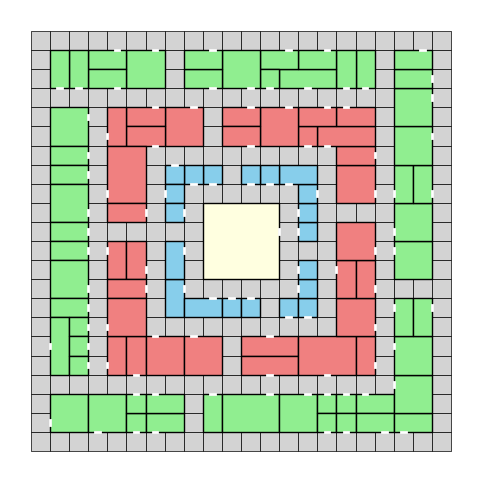

In [10]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=False)

city.plot_city(ax, doors=True, address=False)

# remove axis labels and ticks
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('gc_empty.png')
plt.show(block=False)
plt.close(fig)

Each building row is indexed by a unique identifier: type initial + door cell, e.g. retail at (12,3) -> 'r-x12-y3'.

In [25]:
print("Blocks for 'r-x12-y3':")
print(city.blocks_gdf.loc[city.blocks_gdf['building_id']== 'r-x12-y3', ['coord_x','coord_y']].values.tolist())
building = city.get_building(identifier='r-x12-y3')
print("Door centroid for 'r-x12-y3':", (building.iloc[0]['door_x'], building.iloc[0]['door_y']))

Blocks for 'r-x12-y3':
[[10, 1], [10, 2], [11, 1], [11, 2], [12, 1], [12, 2]]
Door centroid for 'r-x12-y3': (np.float64(12.5), np.float64(3.0))


Once a `City` object has been defined, a `Population` object can be initialized. The `Population` object will contain the `Agents` of the city and generate their trajectories.

In [26]:
# Instantiate population to collect all agents
population = Population(city)

## Agents and trajectories

`Agent`s are tied to a specific `City` instance, and are represented by the `Agent` class. Each `Agent` contains attributes for a work and home location, as well as a 'mobility diary' that is used to generate granular trajectories. When instantiating an `Agent`, their mobility diary can be initialized in two ways:
1. With a user-provided destination diary.
2. Without a diary and then a diary is generated with the EPR model.

These destination diaries are later replaced by a realized mobility diary that takes into account the travel time between buildings and, thus, should be regarded as a mobility plan. 

### User-provided diary initialization

Initializing in this way simply requires passing a `DataFrame` object with appropriate diary columns to the `Agent` constructor. 

In [27]:
# Initialization with custom diary
tz = ZoneInfo("America/New_York")
start_time = pd.date_range(start='2024-01-01 00:00', periods=22, freq='15min', tz=tz)
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [15]*22  # in minutes
location = ['h-x8-y13'] * 2 + ['r-x12-y3'] * 4 + ['w-x15-y15'] * 12 + ['h-x8-y13'] * 4

d_diary = pd.DataFrame({
    "datetime": start_time,
    "timestamp": unix_timestamp,
    "duration": duration,
    "location": location
})

# Rename columns to match what condense_destinations expects
d_diary = d_diary.rename(columns={"datetime": "local_timestamp", "timestamp": "unix_timestamp"})

# Condense the diary
d_diary = tg.condense_destinations(d_diary)

Alice = Agent(identifier="Alice",
              home='h-x8-y13',
              workplace='w-x15-y15',
              city=city)

Alice.generate_trajectory(dt=1, destination_diary=d_diary, seed=100)
 
Alice.diary.head()

Input destination_diary shape: (22, 4)
Input destination_diary columns: ['local_timestamp', 'unix_timestamp', 'duration', 'location']
First few rows of input destination_diary:
            local_timestamp  unix_timestamp  duration  location
0 2024-01-01 00:00:00-05:00      1704085200        15  h-x8-y13
1 2024-01-01 00:15:00-05:00      1704086100        15  h-x8-y13
2 2024-01-01 00:30:00-05:00      1704087000        15  r-x12-y3
3 2024-01-01 00:45:00-05:00      1704087900        15  r-x12-y3
4 2024-01-01 01:00:00-05:00      1704088800        15  r-x12-y3
After sorting, destination_diary shape: (22, 4)
First few rows after sorting:
            local_timestamp  unix_timestamp  duration  location
0 2024-01-01 00:00:00-05:00      1704085200        15  h-x8-y13
1 2024-01-01 00:15:00-05:00      1704086100        15  h-x8-y13
2 2024-01-01 00:30:00-05:00      1704087000        15  r-x12-y3
3 2024-01-01 00:45:00-05:00      1704087900        15  r-x12-y3
4 2024-01-01 01:00:00-05:00      17040888

,datetime,timestamp,duration,location,identifier


The helper function `condense_destinations` simply combines consecutive stops to the same destination. After generating a trajectory with `generate_trajectory` we can see that there are entries with a value of None in the diary, while the destination diary provided was 'complete', this is because the destination diary specifies the building the agent has _planned_ to visit at a given time, but the diary has the information of where the agent's _realized_ location, taking into consideration the travel time between buildings. Hence, a location of None corresponds to `Agent` movement on the streets traveling between buildings.

In [ ]:
Alice.__dict__

### Diary generation with EPR model

If no diary is provided, `Agent`s are initialized with an empty diary. When calling `Population.generate_trajectory`, the destination diary is generated and then a granular trajectory is sampled from it. Unlike the case with a user-provided diary, this option requires specifying the duration of the trajectory, with a parameter `T` specifying the ending datetime, while the `start_time` is provided when creating the Agent. 

The following agent, Bob, is given home `h-x8-y8` and workplace `w-x18-y4`. We generate a trajectory for Bob that lasts a week from midnight January 1, 2024 to midnight January 8, 2024.

In [ ]:
# Initialization and diary generation
Bob = Agent(identifier="Bob",
            home='h-x8-y8',
            workplace='w-x18-y4',
            city=city)

Bob.generate_trajectory(
    end_time=pd.Timestamp('2025-01-08 00:00', tz='America/New_York'),
    dt=1,
    seed=0,
    datetime=pd.Timestamp('2025-01-01 00:00', tz='America/New_York')
)

print(Bob.diary.head())

In [ ]:
Bob.trajectory

To visualize an `Agent`'s trajectory, we can call the `plot_city` method of the `City` class and overlay the points of the trajectory using the `ax.scatter` method of matplotlib.

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
city.plot_city(ax, doors=True, address=False, zorder=1)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

if not Bob.trajectory.empty:
    ax.scatter(x=Bob.trajectory['x'], 
               y=Bob.trajectory['y'], 
               s=0.5, color='red', alpha=0.1)
else:
    pass

plt.savefig("garden-city-one-user.png")
plt.show(block=False)
plt.close(fig)

The following code produces an animation of Bob's movement. We limit the animation to the 24 hours between midnight January 4 to midnight January 5 for speed and tractability of the output.

In [ ]:
produce_animation = False

if produce_animation:
    fig, ax = plt.subplots(figsize=(6, 6))

    city.plot_city(ax=ax, doors=True, address=False, zorder=1)

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

    line, = ax.plot([], [], color='blue', alpha=0.1)
    scatter = ax.scatter([], [], s=8, color='black', alpha=0.5)
    time_text = ax.text(0.5, 0.975, '', transform=ax.transAxes)

    fade_length = 60  # Adjust this to control the length of the fade

    df = Bob.trajectory[5760:7200]  # 0:00 Jan 4 – 0:00 Jan 5

    def update(i):
        if i < fade_length:
            current_fade_length = i + 1
        else:
            current_fade_length = fade_length
        alphas = np.array([np.exp(-0.5*x) for x in range(current_fade_length)][::-1])

        line.set_data(df['x'].iloc[:i], df['y'].iloc[:i])
        scatter.set_offsets(df[['x', 'y']].iloc[:i])
        scatter.set_alpha(np.pad(alphas, (i + 1 - current_fade_length, 0), 'constant'))
        time_text.set_text(df['datetime'].iloc[i].strftime('%Y-%m-%d %H:%M:%S'))
        time_text.set_position((0.38, 0.965))
        time_text.set_fontsize(8)
        return line, scatter

    anim = FuncAnimation(fig, update, frames=len(df), interval=50, blit=True)
    anim.save('anim-epr.gif', writer=PillowWriter(fps=20))
    plt.close(fig)

## Sparsifying a complete trajectory

To simulate realistic GPS trajectory data with the sparsity and clusters of pings (or 'burstiness') observed in commercial datasets, we make use of self-exciting point processes—a type of stochastic process that naturally captures triggering and clustering behavior. From a complete ground-truth trajectory, a sparsifed trajectory can be sampled via the `Agent.sample_traj_hier_nhpp` function.

The sampling function `Agent.sample_traj_hier_nhpp` is controlled by three parameters: 
* `beta_start`: the start times of bursts occur according to a Poisson Process with rate 1/`beta_start`
* `beta_dur`: the duration of bursts are sampled from a Exponential distribution with rate 1/`beta_dur`
* `beta_ping`: within a burst, pings are sampled according to a Poisson Process with rate 1/`beta_ping`

These parameters can be interpreted as follows: A burst is expected every `beta_start` minutes and lasts an expected `beta_dur` minutes. Within the burst, a ping is expected to be sampled every `beta_ping` minutes.

Moreover, GPS measurements are often subject to horizontal errors due to various factors like signal obstruction and atmospheric conditions. As such, the sampling function also adds Gaussian noise to the true positions, with the horizontal accuracy indicated in the 'ha' column of the output.

In the example below, we sample from Bob's complete trajectory with the following parameters: `beta_start`=300, `beta_dur`=60, and `beta_ping`=10. 

In [ ]:
# Sample sparse trajectory and latent variables for Bob
burst_info = Bob.sample_trajectory(
    beta_start=300, # a burst every 300 mins on average
    beta_durations=60, # average burst duration is 60 mins
    beta_ping=10, # a ping every 10 mins within a burst
    seed=2,
    output_bursts=True)
Bob.sparse_traj.head()

To visualize the distribution of the sparsified pings, set `output_bursts=True` when calling `Agent.sample_traj_hier_nhpp` to obtain information about the start time and duration of bursts. These can then be graphed alongside the sampled pings to visualize the sparsification. The start times are indicated by the red lines and the duration of bursts are shown by grey rectangles. The sampled pings are the black lines.

In [ ]:
fig, axes = plt.subplots(nrows=3,figsize=(10, 3))
for ax in axes:
    ax.set(xlim=(pd.Timestamp('2025-01-01 05:00', tz='America/New_York'), 
                 pd.Timestamp('2025-01-01 22:00', tz='America/New_York')))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    [spine.set_visible(False) for name, spine in ax.spines.items() if name != 'bottom']
    ax.yaxis.set_visible(False)

# Plot burst start times (Ns)
axes[0].vlines(burst_info['timestamp'], 0.1, 0.9, color='red', linewidth=1.2)
axes[0].set_title('a) Burst start times', loc='left', fontsize=10)

# Plot burst end times (Ne)
for _, row in burst_info.iterrows():
    end_time = row.get('end_time', row['timestamp'] + pd.Timedelta(minutes=5).total_seconds())  # Fallback if end_time is missing
    axes[1].fill_betweenx([0, 1], row['timestamp'], end_time, color='lightgrey', zorder=1)
axes[1].vlines(burst_info.get('end_time', burst_info['timestamp'] + pd.Timedelta(minutes=5).total_seconds()), 0, 1, color='blue', linewidth=1.2)
axes[1].set_title('b) Burst end times', loc='left', fontsize=10)

# Plot pings (N)
axes[2].vlines(Bob.sparse_traj['datetime'], 0, 1, color='black', linewidth=1)
axes[2].set_title('c) Ping times', loc='left', fontsize=10)

fig.subplots_adjust(hspace=2)
fig.savefig("nhpp-sampling.png", bbox_inches='tight')
plt.show(block=False)
plt.close(fig)

# Generating multiple agents

A `Population` may contain any number of `Agent`s, which can be initialized en masse using the `Population.generate_agents` method. Each `Agent` is assigned a random name as well as a uniformly sampled home and workplace. The `start_time` parameter indicates the time at which all the `Agent`s start their trajectories.

`Agent` trajectories can be generated by looping over each `Agent` and running the `Population.generate_trajectory` function as explained above. 

_Note: if using a seed, make sure that each agent's seed is different to avoid all agents having the same trajectory._

In [ ]:
population = Population(city)
population.generate_agents(N=5,
                            seed=100)

for i, agent_id in enumerate(population.roster):
    agent = population.roster[agent_id]
    agent.generate_trajectory(end_time=pd.Timestamp('2025-01-08 00:00', tz='America/New_York'),
                              datetime=pd.Timestamp('2025-01-01 00:00', tz='America/New_York'),
                              seed=100+i)
    agent.sample_trajectory(beta_start=300,
                            beta_durations=60,
                            beta_ping=10,
                            seed=100+i)

population.roster

Any individual `Agent` can be accessed by calling their identifier through the `Population.roster` dictionary. 

In [ ]:
nifty_saha = population.roster['nifty_saha']
print("Diary:\n", nifty_saha.diary.head())
print("\nTrajectory:\n", nifty_saha.trajectory.head())
print("\nSparse Trajectory:\n", nifty_saha.sparse_traj.head())

# Example 1: testing stop detection algorithms

As a demonstration of our generative model, we adapt the robustness experiment proposed in Barreras and Watts (2024), which aimed to show that common stop detection algorithms can be impacted by ping sparsity. Our generation of sparse ping times allows for modeling the clustering of pings into bursts, which can produce a more nuanced notion of `sparsity' than overall ping frequency. This toy example reveals how global sparsity might be an inadequate metric to use for calibrating stop-detection algorithms since, even when keeping it constant, changes in the clustering pattern of pings results in important variations of the output and can cause the same problems—such as omitting, merging, or splitting stops.

We first initialize an `Agent` (Charlie) and generate a complete ground-truth trajectory. The destination diary is manually initialized as consecutive 1-hour visits to two homes followed by a 3-hour visit at a larger retail building.

In [ ]:
tz = ZoneInfo("America/New_York")
start_time = pd.date_range(start='2024-06-01 00:00', periods=5, freq='60min', tz=tz)
tz_offset = loader._offset_seconds_from_ts(start_time[0])
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*5  # in minutes
location = ['h-x13-y11'] * 1 + ['h-x13-y8'] * 1 + ['r-x18-y10'] * 3

destination = pd.DataFrame(
    {"datetime":start_time,
     "unix_timestamp":unix_timestamp,
     "duration":duration,
     "location":location}
     )
destination = tg.condense_destinations(destination)

Charlie = Agent(identifier="Charlie",
                home='h-x13-y11',
                workplace='w-x15-y9',
                city=city)

Charlie.generate_trajectory(destination_diary=destination, seed=75)

Charlie.diary

Charlie's ground-truth trajectory is plotted below.

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.scatter(x=Charlie.trajectory.x, 
           y=Charlie.trajectory.y, 
           s=6, color='black', alpha=1, zorder=2)
city.plot_city(ax, doors=True, address=False, zorder=1)

ax.plot(Charlie.trajectory.x,
        Charlie.trajectory.y,
        linewidth=1, color='blue', alpha=0.2)

ax.set_xlim(12, 22)
ax.set_ylim(7, 14)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig("exp1-trajectory.png")
plt.show(block=False)
plt.close(fig)

We sample Charlie's ground-truth trajectory at two levels of sparsity. 
* The higher sparsity sample uses parameters `beta_start`=150, `beta_dur`=20, and `beta_ping`=2. 
* The lower sparsity sample uses parameters `beta_start`=60, `beta_dur`=40, and `beta_ping`=10. 

The high sparsity sample expects a burst every 2.5 hours with a mean length of 20 minutes and a ping expected roughly every 2 minutes within the burst, for an expected total burst period of 40 minutes over 5 hours. The low sparsity sample expects a burst every hour with a mean length of 40 minutes and a ping expected roughly every 5 minutes within the burst, for an expected total burst period of 200 minutes over 5 hours.

Note that both sparsity levels expect 20 pings over the 5-hour duration. We deliberately choose these parameters to hold overall ping frequency fixed in order to isolate the effect of the burstiness pattern.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))
hier_nhpp_params = [(150, 20, 2), (60, 40, 10)]
seed = 819

for j in range(2):
    ax = axes[j]
    Charlie.sample_trajectory(*hier_nhpp_params[j], seed=seed, replace_sparse_traj=True)

    ax.scatter(Charlie.sparse_traj.x, Charlie.sparse_traj.y, s=6, color='black', alpha=1, zorder=2)
    city.plot_city(ax, doors=True, address=False, zorder=1)

    ax.set_xlim(12, 22)
    ax.set_ylim(7, 14)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

axes[0].set_xlabel('a) Lower Local Sparsity', fontsize='x-large')
axes[1].set_xlabel('b) Higher Local Sparsity ', fontsize='x-large')

plt.tight_layout()
plt.savefig("exp1-sparse.png")
plt.show(block=False)
plt.close(fig)

The distribution of the pings as well as the burst durations for both levels of local sparsity are plotted below.

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 2))

for j in range(2):
    ax = axes[j]
    ax.set(xlim=(pd.Timestamp('2024-06-01 00:00', tz='America/New_York'), 
                 pd.Timestamp('2024-06-01 05:00', tz='America/New_York')))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    [spine.set_visible(False) for name, spine in ax.spines.items() if name != 'bottom']
    ax.yaxis.set_visible(False)

    burst_info = Charlie.sample_trajectory(
        *hier_nhpp_params[j], 
        seed=seed, 
        output_bursts=True,
        replace_sparse_traj=True)

    #ax.vlines(burst_info['start_time'], 0.95, 1.05, color='red', linewidth=1.2, alpha=1)

    for i, row in burst_info.iterrows():
        end_time = row.get('end_time', row['timestamp'] + pd.Timedelta(minutes=5).total_seconds())
        ax.fill_betweenx(
            [0.95, 1.05],
            row['timestamp'],
            end_time,
            color='lightgrey',
            zorder=1
        )

    ax.vlines(Charlie.sparse_traj['datetime'], 0.95, 1.05, color='black', linewidth=0.8, alpha=1)

axes[0].set_title('a) Lower Local Sparsity', loc='left', fontsize=10)
axes[1].set_title('b) Higher Local Sparsity ', loc='left', fontsize=10)

fig.subplots_adjust(hspace=2)
fig.savefig("exp1-sparsity-levels.png", bbox_inches='tight')
plt.show(block=False)
plt.close(fig)

We are interested in how the sparsity of the trajectory and parameterization of stop detection algorithms interact. Here, we use a temporal version of DBSCAN to cluster pings into stops. DBSCAN takes three parameters: `time_thresh`, `dist_thresh`, and `min_pts`. Roughly, a point is considered part of a dense cluster if it has at least `min_pts` neighboring points within a distance `dist_thresh` and time gap `time_thresh`; otherwise, it is labeled as noise. 

We explore a fine and a coarse parameterization of DBSCAN and apply each to the higher and lower sparsity trajectories.

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(9, 6))
dbscan_params = [(120, 2.25, 2), (45, 1, 3)]
traj_cols = {
    'user_id': 'identifier',
    'x': 'x',
    'y': 'y',
    'timestamp': 'timestamp'
}

for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        Charlie.sample_trajectory(*hier_nhpp_params[j], seed=seed, replace_sparse_traj=True)

        dbscan_out = DBSCAN.ta_dbscan_labels(
            Charlie.sparse_traj,
            dist_thresh=dbscan_params[i][1],
            min_pts=dbscan_params[i][2],
            time_thresh=dbscan_params[i][0],
            traj_cols=traj_cols,
            return_cores=True
        )

        num_clusters = int((dbscan_out.cluster.unique() > -1).sum())
        for cid in range(num_clusters):
            cpings = dbscan_out[dbscan_out.cluster == cid]
            cdata = Charlie.sparse_traj.loc[cpings.index]
            col = cm.tab20c(cid/(num_clusters+1))
            ax.scatter(cdata.x, cdata.y, s=80, color=col, alpha=1, zorder=2)

        ax.scatter(Charlie.sparse_traj.x, Charlie.sparse_traj.y, s=6, color='black', alpha=1, zorder=2)
        city.plot_city(ax, doors=True, address=False, zorder=1)

        ax.set_xlim(12, 22)
        ax.set_ylim(7, 14)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

axes[0, 0].set_ylabel('Coarse', fontsize='x-large')
axes[1, 0].set_ylabel('Fine', fontsize='x-large')
axes[1, 0].set_xlabel('Lower Local Sparsity', fontsize='x-large')
axes[1, 1].set_xlabel('Higher Local Sparsity', fontsize='x-large')

plt.tight_layout()
plt.savefig("exp1-stdbscan.png")
plt.show(block=False)
plt.close(fig)

In the top left panel, we observe "stop merging", wherein a coarser parametrization struggles to differentiate stops at small neighboring establishments and instead clusters two stops as one. Conversely, a finer parametrization may completely miss a stop at a larger location (as in the bottom left panel) or erroneously cluster a larger stop as two distinct, shorter stops (as in the bottom right panel). Only the top right panel in this example accurately detected the three stops. Thus, it seems like the optimal parameters for a given trajectory could be selected based on the clustering structure and not only on the ping frequency.

# Example 2: The effect of noise on stops and dwell time

We simulate two agents with the same destination diary but different variance parameters. Both agents spend two hours at the park but one agent (Daniel) stays still with probability 0.75 and moves around with a slower speed ($\sigma_{\text{park}} = 1.5/1.96$) whereas the other agent (Elaine) stays still with probability 0.1 and moves around with a faster speed ($\sigma_{\text{park}} = 2.5/1.96$). These agent attributes are governed by the input of SLOW_STILL_PROBS (or FAST_STILL_PROBS) and SLOW_SPEEDS (or FAST_SPEEDS) during agent initialization. 

In [ ]:
tz = ZoneInfo("America/New_York")
start_time = pd.date_range(start='2024-06-01 00:00', periods=2, freq='60min', tz=tz)
tz_offset = loader._offset_seconds_from_ts(start_time[0])
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*2  # in minutes

location = ['p-x13-y11'] * 2

destination = pd.DataFrame({
    "datetime": start_time,
    "timestamp": unix_timestamp,
    "duration": duration,
    "location": location
})
destination = tg.condense_destinations(destination)

init_trajectory = pd.DataFrame([{
    'x': 11.0,
    'y': 11.0,
    'datetime': pd.Timestamp('2024-06-01 00:00', tz='America/New_York'),
    'timestamp': int(pd.Timestamp('2024-06-01 00:00', tz='America/New_York').timestamp()),
    'identifier': "Daniel"
}])

init_diary = pd.DataFrame([{
    'datetime': pd.Timestamp('2024-06-01 00:00', tz='America/New_York'),
    'timestamp': int(pd.Timestamp('2024-06-01 00:00', tz='America/New_York').timestamp()),
    'duration': 1,
    'location': 'p-x13-y11'
}])

# Condense the destination diary
d_diary = pd.DataFrame(Bob.destination_diary)
# Before condense_destinations
# print("Before condense_destinations, d_diary columns:", d_diary.columns.tolist())
# print("First few rows of d_diary before condensing:")
# print(d_diary.head())
d_diary = tg.condense_destinations(d_diary)
# After condense_destinations
# print("After condense_destinations, d_diary columns:", d_diary.columns.tolist())
# print("First few rows of d_diary after condensing:")
# print(d_diary.head())

# Daniel is slow
Daniel = Agent(identifier="Daniel",
            home='p-x13-y11',
            workplace='w-x15-y9',
            city=city,
            still_probs=SLOW_STILL_PROBS,
            speeds=SLOW_SPEEDS,
            trajectory=init_trajectory,
            diary=init_diary)
population.add_agent(Daniel)
Daniel.generate_trajectory(destination_diary=destination, seed=50)

# Elaine is fast
Elaine = Agent(identifier="Elaine",
            home='p-x13-y11',
            workplace='w-x15-y9',
            city=city,
            still_probs=FAST_STILL_PROBS,
            speeds=FAST_SPEEDS,
            trajectory=init_trajectory,
            diary=init_diary)
population.add_agent(Elaine)
Elaine.generate_trajectory(destination_diary=destination, seed=50)

Daniel and Elaine's ground-truth trajectories are plotted below.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

for j in range(2):
    ax = axes[j]
    agent = [Daniel, Elaine][j]

    ax.scatter(x=agent.trajectory.x, 
           y=agent.trajectory.y, 
           s=6, color='black', alpha=1, zorder=2)
    city.plot_city(ax, doors=True, address=False, zorder=1)

    ax.plot(agent.trajectory.x,
            agent.trajectory.y,
            linewidth=1, color='blue', alpha=0.2)

    ax.set_xlim(7, 15)
    ax.set_ylim(7, 15)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

axes[0].set_xlabel('Low Variance', fontsize='x-large')
axes[1].set_xlabel('High Variance', fontsize='x-large')

plt.tight_layout()
plt.savefig("exp2-trajectories.png")
plt.show(block=False)
plt.close(fig)

As an additional source of variance, we sample Daniel's trajectory with a lower horizontal noise of `ha=0.75` and Elaine's trajectory with a higher horizontal noise of `ha=1.5`.

We are interested in how the variance of the trajectory affects stop detection results. Here, we use another clustering algorithm known as Project Lachesis, which takes three parameters: `dur_min`, `dt_max`, and `delta_roam`. The Lachesis algorithm greedily incorporates pings into a cluster as long as the cluster has a diameter of at most `delta_roam`, no time gaps larger than `dt_max`, and a duration larger than `dur_min`.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
hier_nhpp_params = (10, 1000, 5)
lachesis_params = (15, 30, 3)
ha = [3/4, 5/4]
seed = 105

for j in range(2):
    ax = axes[j]
    agent = [Daniel, Elaine][j]

    agent.sample_trajectory(*hier_nhpp_params, seed=seed, ha=ha[j], replace_sparse_traj=True)

    lachesis_out = Lachesis.lachesis_labels(
        agent.sparse_traj,
        dt_max=lachesis_params[1],
        delta_roam=lachesis_params[0],
        dur_min=lachesis_params[2],
        traj_cols=traj_cols
    )
    lachesis_stays = Lachesis.lachesis(
        agent.sparse_traj,
        delta_roam=lachesis_params[0],
        dt_max=lachesis_params[1],
        dur_min=lachesis_params[2],
        traj_cols=traj_cols,
        complete_output=False
    )

    # compute total stop duration
    total_stop_duration = lachesis_stays["duration"].sum()
    
    num_clusters = len(lachesis_stays)
    for cid in range(num_clusters):
        cpings = lachesis_out[lachesis_out == cid].index
        cdata = agent.sparse_traj.loc[cpings]
        col = cm.tab20c(cid/(num_clusters))
        ax.scatter(cdata.x, cdata.y, s=80, color=col, alpha=1, zorder=2)

    ax.scatter(agent.sparse_traj.x, agent.sparse_traj.y, s=6, color='black', alpha=1, zorder=2)
    city.plot_city(ax, doors=True, address=False, zorder=1)

    ax.set_xlim(7, 15)
    ax.set_ylim(7, 15)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

    lohi = ['Low', 'High'][j]
    ax.set_xlabel(f'{lohi} Variance\nTotal stop duration: {total_stop_duration} minutes', fontsize=12)

plt.tight_layout()
plt.savefig("exp2-lachesis.png")
plt.show(block=False)
plt.close(fig)

Plot shortest path between two buildings
if True:
    import matplotlib.pyplot as plt
    from shapely.geometry import LineString
    
    fig, ax = plt.subplots(figsize=(10, 10))
    city.plot_city(ax, doors=True, address=False)
    
    # Example: Plot shortest path between two buildings
    start_building_id = 'r-x12-y3'
    end_building_id = 'r-x15-y5'
    
    # Get building door coordinates using get_building method
    start_building = city.get_building(identifier=start_building_id)
    end_building = city.get_building(identifier=end_building_id)
    
    if start_building is not None and not start_building.empty and end_building is not None and not end_building.empty:
        start_door = (start_building['door_cell_x'].iloc[0], start_building['door_cell_y'].iloc[0])
        end_door = (end_building['door_cell_x'].iloc[0], end_building['door_cell_y'].iloc[0])
        print(f"Plotting shortest path from door {start_door} to door {end_door}")
        city.get_shortest_path(start_door, end_door, plot=True, ax=ax)
    else:
        print(f"Could not find buildings 'r-x12-y3' or 'r-x15-y5'")
    
    ax.legend()
    plt.title(f'Shortest Path from {start_building_id} to {end_building_id}')
    plt.show(block=False)
    plt.close(fig)